# Fine tuning usando Fast AutoAugment - Experimento

Este componente utiliza o três arquiteturas presentes na biblioteca [PyTorch](https://pytorch.org/) para a tarefa de classificação de imagens. São elas: ResNet-18, ResNet-50 e VGG16.    
Cada uma das arquiteturas é treinada aplicando-se no conjunto de treino e validação um dos 3 conjuntos de polices genéricas definidas pelo artigo [Fast AutoAugment](https://arxiv.org/pdf/1905.00397.pdf), sujo código está disponibilizado no [GitHub](https://github.com/kakaobrain/fast-autoaugment).

Ao final, o modelo de maior acurácia no conjunto de validação para o dataset utilizado será salvo para futura utilização.
#### **Em caso de dúvidas, consulte os [tutoriais da PlatIAgro](https://platiagro.github.io/tutorials/).**

## Declaração de parâmetros e hiperparâmetros

Declare parâmetros com o botão  na barra de ferramentas.<br>
O parâmetro `dataset` identifica os conjuntos de dados. Você pode importar arquivos de dataset com o botão  na barra de ferramentas.

Para esse componente, a base de dados deve estar no seguinte formado:
- Imagens coloridas (3 canais) no formato 224x224 pixels. Caso não estejam nesse formato, o código faz as alterações necesssárias
- Cada classe tem sua pasta com suas respectivas imagens, além dos conjuntos de treino, validação e teste terem suas pastas separadas. Um exemplo da árvore de diretórios pode ser observado abaixo:

```bash
dataset
|
|________train
|        |_____class_name1
|        |     |____image0.jpg
|        |     |____image1.jpg
|        |     ...
|        |
|        |_____class_name2
|              |____image3.jpg
|              |____image4.jpg
|               ...
|
|________val
|        |_____class_name1
|        |     |____image5.jpg
|        |     |____image6.jpg
|        |     ...
|        |
|        |_____class_name2
|              |____image7.jpg
|              |____image8.jpg
|               ...
|
|________test
|        |_____class_name1
|        |     |____image9.jpg
|        |     |____image10.jpg
|        |     ...
|        |
|        |_____class_name2
|              |____image11.jpg
|              |____image12.jpg
|              ...
```

In [1]:
dataset = "/tmp/data/hymenoptera_data-5.zip" #@param {type:"string"}

# Lista de arquiteturas disponívels: [resnet18, resnet50, vgg16]
arch_list = ["resnet18", "resnet50", "vgg16"]
# Lista de polices disponíveis:
aug_polices = ["fa_reduced_cifar10", "fa_resnet50_rimagenet", "fa_reduced_svhn"]
# Nome base para salvar os modelos
dataset_id = "hymenoptera"
# Caminho para salvar os checkpoints dos modelos treinados
checkpoint_path = "/tmp/data/models-output/"
# Caminha para salvar as imagens dos gráficos de loss e acurácia relativos aos treinamentos
output_graphs = "/tmp/data/eval-images/"
# Número de classes presentes no conjunto de dados
num_of_classes = 2
# Quantas predições queremos.
# Deve ser menor ou igual ao número de classes
top_predictions = 1

# variáveis utilizadas na etapa de treinamento do modelo
batch = 64
epochs = 4
lr = 0.001
gamma = 0.1
step_size = 7
momentum = 0.1

In [1]:
# Variáveis globais. Não modificar as 3 linhas abaixo.
ARCH_LIST = ['resnet18', 'resnet50', 'vgg16']
POLICES_LIST = ['fa_reduced_cifar10', 'fa_resnet50_rimagenet', 'fa_reduced_svhn']
CSV_FILENAME = "/tmp/data/best_models_acc.csv"

## Extração de dados do arquivo .zip


In [2]:
import os
import zipfile

root_folder_name = dataset.split("/")[-1].split(".")[0]
root_folder = os.path.join("/tmp/data", root_folder_name)
with zipfile.ZipFile(dataset, 'r') as zip_ref:
   zip_ref.extractall(root_folder)

os.makedirs(checkpoint_path, exist_ok=True)
os.makedirs(output_graphs, exist_ok=True)

## Classificação de Images

In [3]:
# Auxiliar functions to print trained models infos 
# and select best model

def save_to_csv(csv_path, arch, police, val_acc):
    """Save a csv file with best models infos"""
    data = {
        "dataset": [dataset_id],
        "architecture_id": [arch],
        "police_id": [police],
        "val_acc": [val_acc]}
    dataframe = pd.DataFrame(data)
    output_path = os.path.join(csv_path, CSV_FILENAME)
    if os.path.isfile(output_path):
        dataframe.to_csv(output_path, mode="a", header=False, index=False)
    else:
        dataframe.to_csv(output_path, index=False)

def best_models_stats(csv):
    """Print best model and all trained models"""
    dataframe = pd.read_csv(csv)
    dataframe.sort_values(by=["val_acc"], inplace=True, ascending=False)
    dataframe.reset_index(drop=True, inplace=True)
    best_cases = dataframe.loc[dataframe['dataset'] == dataset_id].head()
    print("### TOP 5 BEST MODELS ON {0} DATASET ###\n".format(dataset_id))
    print(best_cases, "\n")
    print("### ALL MODELS TRAINED ON {0} DATASET ### \n".format(dataset_id))
    print(dataframe.loc[dataframe['dataset'] == dataset_id], "\n")
    
    best_model = best_cases.iloc[0]
    return best_model

In [4]:
!wget https://raw.githubusercontent.com/platiagro/tasks/feature/finetuning-autoaugment/tasks/fine-tunning-autoaugment/archive.py
!wget https://raw.githubusercontent.com/platiagro/tasks/feature/finetuning-autoaugment/tasks/fine-tunning-autoaugment/augmentations.py
!wget https://raw.githubusercontent.com/platiagro/tasks/feature/finetuning-autoaugment/tasks/fine-tunning-autoaugment/checkpoint.py
!wget https://raw.githubusercontent.com/platiagro/tasks/feature/finetuning-autoaugment/tasks/fine-tunning-autoaugment/data.py
!wget https://raw.githubusercontent.com/platiagro/tasks/feature/finetuning-autoaugment/tasks/fine-tunning-autoaugment/finetuning.py
!wget https://raw.githubusercontent.com/platiagro/tasks/feature/finetuning-autoaugment/tasks/fine-tunning-autoaugment/models.py
!wget https://raw.githubusercontent.com/platiagro/tasks/feature/finetuning-autoaugment/tasks/fine-tunning-autoaugment/networks.py
!wget https://raw.githubusercontent.com/platiagro/tasks/feature/finetuning-autoaugment/tasks/fine-tunning-autoaugment/visualizations.py

--2020-12-28 16:25:29--  https://raw.githubusercontent.com/platiagro/tasks/feature/finetuning-autoaugment/tasks/fine-tunning-autoaugment/archive.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.176.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.176.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 177844 (174K) [text/plain]
Saving to: ‘archive.py’

archive.py          100%[===================>] 173.68K  --.-KB/s    in 0.04s   

2020-12-28 16:25:29 (4.56 MB/s) - ‘archive.py’ saved [177844/177844]

--2020-12-28 16:25:30--  https://raw.githubusercontent.com/platiagro/tasks/feature/finetuning-autoaugment/tasks/fine-tunning-autoaugment/augmentations.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.176.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.176.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5928 (5.8K) [

In [5]:
import os
import sys
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch import cuda
from torch.optim import lr_scheduler

from data import LoadData
from finetuning import FineTuning
from visualizations import ImageVisualization
from checkpoint import Checkpoint
from models import Model, ModelInfos

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device, type(device))

multi_gpu = False
if cuda.is_available():
    gpu_count = cuda.device_count()
    print(gpu_count, ' gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
l_data = LoadData(root_folder)
checkpoint = Checkpoint(dataset_id, multi_gpu, checkpoint_path)
criterion = nn.CrossEntropyLoss()
model_ft = FineTuning(arch_list, num_of_classes)

cpu <class 'torch.device'>


### 1. Treinamento dos modelos

11,308,354 total parameters.
131,842 total gradient parameters.

######
Model architecture: resnet18
Police: fa_reduced_cifar10
Epochs trained: 4
Start to training a model.

Training completed in 0m 0s
Best val Acc: 0.8431
24,033,090 total parameters.
525,058 total gradient parameters.

######
Model architecture: resnet50
Police: fa_reduced_cifar10
Epochs trained: 4
Start to training a model.

Training completed in 0m 0s
Best val Acc: 0.8954
21,137,986 total parameters.
6,423,298 total gradient parameters.

######
Model architecture: vgg16
Police: fa_reduced_cifar10
Epochs trained: 1
Start to training a model.
Epoch 1/3



/home/jovyan/tasks/FineTunning_AutoAugment/networks.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = self.softmax(out)


train Loss: 0.3427 Acc: 0.8648
val Loss: 0.2733 Acc: 0.9085
Epoch 2/3

train Loss: 0.2764 Acc: 0.8934
val Loss: 0.2371 Acc: 0.9281
Epoch 3/3

train Loss: 0.2556 Acc: 0.8934
val Loss: 0.2804 Acc: 0.8889

Training completed in 11m 55s
Best val Acc: 0.9281

######
Model architecture: resnet18
Police: fa_resnet50_rimagenet
Start to training a model.
Epoch 1/4

train Loss: 0.6935 Acc: 0.5410
val Loss: 0.6375 Acc: 0.6797
Epoch 2/4

train Loss: 0.6815 Acc: 0.5738
val Loss: 0.6005 Acc: 0.8431
Epoch 3/4

train Loss: 0.6480 Acc: 0.5738
val Loss: 0.6008 Acc: 0.7320
Epoch 4/4

train Loss: 0.6368 Acc: 0.6680
val Loss: 0.5497 Acc: 0.8105

Training completed in 3m 25s
Best val Acc: 0.8431

######
Model architecture: resnet50
Police: fa_resnet50_rimagenet
Start to training a model.
Epoch 1/4

train Loss: 0.6887 Acc: 0.5492
val Loss: 0.6710 Acc: 0.6536
Epoch 2/4

train Loss: 0.6723 Acc: 0.5984
val Loss: 0.6364 Acc: 0.8170
Epoch 3/4

train Loss: 0.6478 Acc: 0.6803
val Loss: 0.6140 Acc: 0.8170
Epoch 4/4


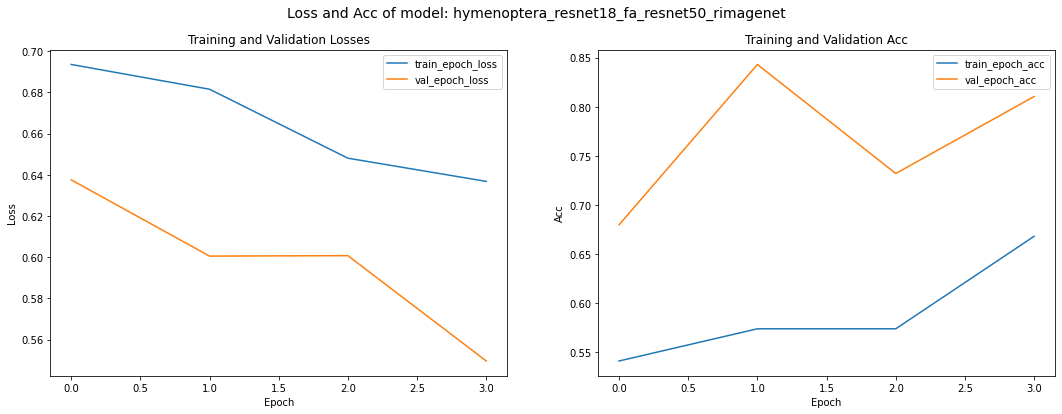

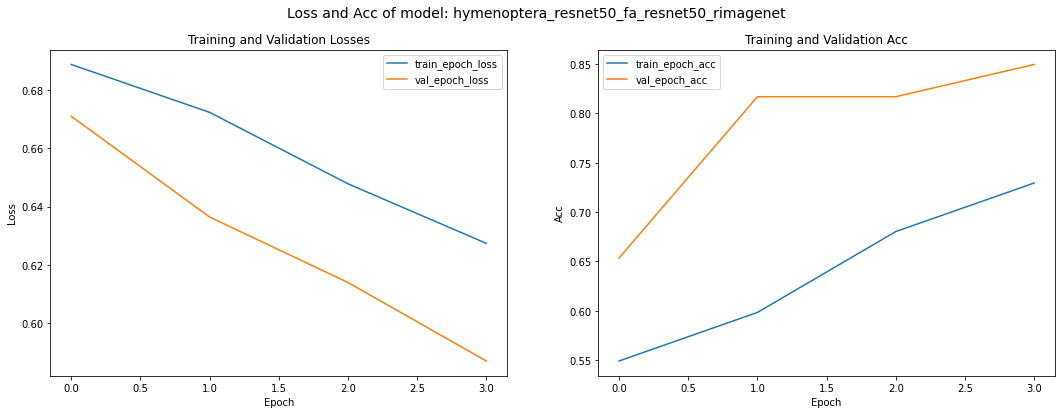

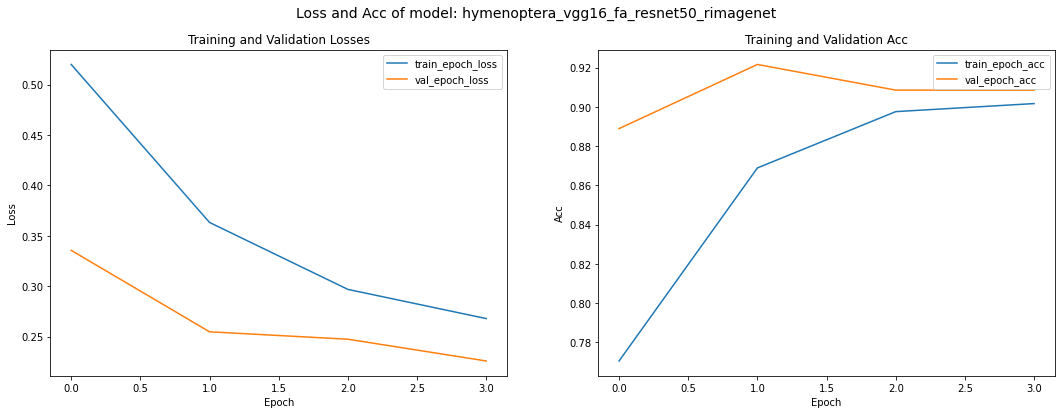

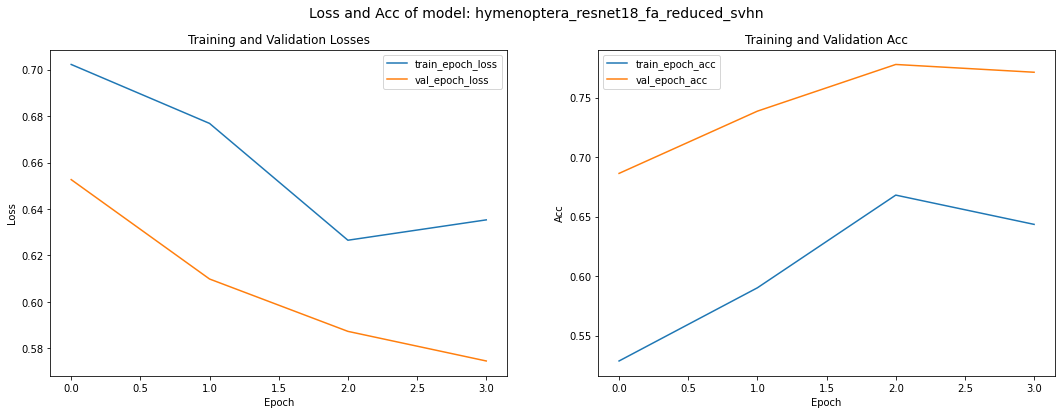

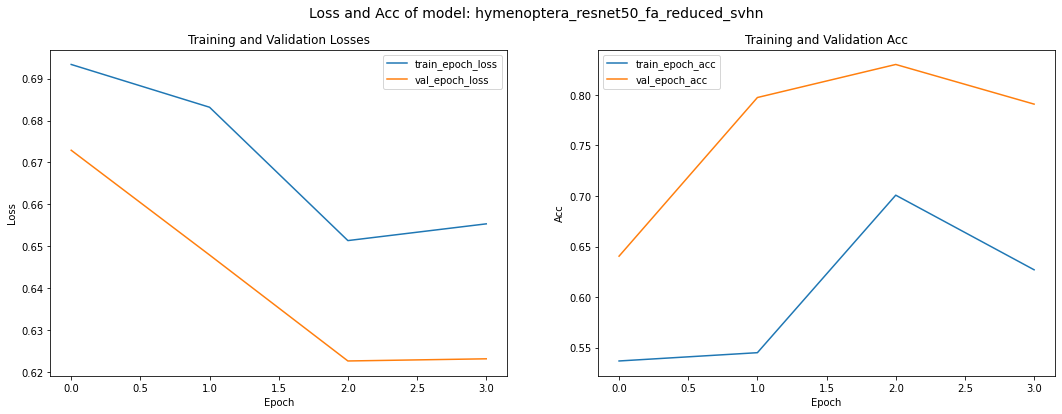

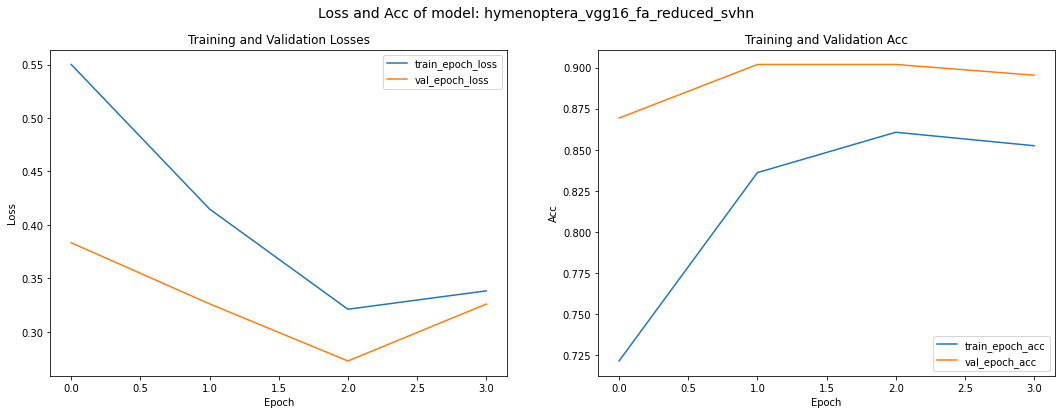

In [6]:
for police in aug_polices:
    assert (police in POLICES_LIST), 'police not found'
    dataloaders, dataset_sizes, class_names = l_data.load_data_train(police)
    visual = ImageVisualization(device, dataloaders, output_graphs)
    for arch in arch_list:
        assert (arch in ARCH_LIST), 'archictecture not supported'
        model_train = Model(arch, device, checkpoint)
        model_name = "{0}_{1}_{2}".format(dataset_id, arch, police)
        model_path = os.path.join(checkpoint_path, model_name)

        if not os.path.exists(model_path):
            model_conv = model_ft.fine_tuning(arch)
            optimizer_conv = optim.SGD(
                model_conv.parameters(),
                lr=lr, momentum=momentum)
            exp_lr_scheduler = lr_scheduler.StepLR(
                optimizer_conv, step_size=step_size, gamma=gamma)
            model_conv, best_model_val_acc = model_train.train_model(
                model_conv, police, dataloaders, dataset_sizes, criterion,
                optimizer_conv, exp_lr_scheduler, num_epochs=epochs)
            save_to_csv(checkpoint_path, arch, police, best_model_val_acc)
            visual.visualize_results(model_conv.history, dataset_id + '_' + arch + '_' + police)

        elif os.path.exists(model_path):
            model_checkpoint = checkpoint.load_checkpoint(
                arch,
                checkpoint_path + dataset_id + '_' + arch + '_' + police)
            exp_lr_scheduler = lr_scheduler.StepLR(
                model_checkpoint.optimizer, step_size=step_size,
                gamma=gamma)
            model_checkpoint, best_model_val_acc = model_train.train_model(
                model_checkpoint, police, dataloaders,dataset_sizes, criterion,
                model_checkpoint.optimizer, exp_lr_scheduler, num_epochs=epochs)
            save_to_csv(checkpoint_path, arch, police, best_model_val_acc)

In [7]:
best_model = best_models_stats(os.path.join(checkpoint_path, CSV_FILENAME))
best_model_name = "{0}_{1}_{2}".format(best_model['dataset'], best_model['architecture_id'], best_model['police_id'])
best_model_path = os.path.join(checkpoint_path, best_model_name)

### TOP 5 BEST MODELS ON hymenoptera DATASET ###

       dataset architecture_id              police_id   val_acc
0  hymenoptera           vgg16     fa_reduced_cifar10  0.928105
1  hymenoptera           vgg16  fa_resnet50_rimagenet  0.921569
2  hymenoptera           vgg16        fa_reduced_svhn  0.901961
3  hymenoptera        resnet50     fa_reduced_cifar10  0.895425
4  hymenoptera        resnet50     fa_reduced_cifar10  0.895425 

### ALL MODELS TRAINED ON hymenoptera DATASET ### 

        dataset architecture_id              police_id   val_acc
0   hymenoptera           vgg16     fa_reduced_cifar10  0.928105
1   hymenoptera           vgg16  fa_resnet50_rimagenet  0.921569
2   hymenoptera           vgg16        fa_reduced_svhn  0.901961
3   hymenoptera        resnet50     fa_reduced_cifar10  0.895425
4   hymenoptera        resnet50     fa_reduced_cifar10  0.895425
5   hymenoptera        resnet50  fa_resnet50_rimagenet  0.849673
6   hymenoptera        resnet18     fa_reduced_cifar10  0

### 2. Teste do melhor modelo

In [8]:
model_path = best_model_path
dataloaders, dataset_sizes, class_names = l_data.load_data_test()

# Run inference for test set
model = Model(best_model['architecture_id'], device)
running_corrects, running_wrongs, acc = model.predict_batch(
    multi_gpu,
    model_path,
    dataloaders,
    dataset_sizes)
print("Corrects: {0}\nWrongs: {1}\nAcc: {2}".format(
    running_corrects,
    running_wrongs,
    acc))

['ants', 'bees'] {'test': 15}
21,137,986 total parameters.
6,423,298 total gradient parameters.


/home/jovyan/tasks/FineTunning_AutoAugment/networks.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = self.softmax(out)


Corrects: 15
Wrongs: 0
Acc: 1.0


## Salva métricas
Utiliza a função `save_metrics` do [SDK da PlatIAgro](https://platiagro.github.io/sdk/) para salvar métricas. Por exemplo: `accuracy`, `precision`, `r2_score`, `custom_score` etc.<br>

In [9]:
from platiagro import save_metrics

save_metrics(accuracy=acc)

## Salva modelo e outros resultados do treinamento

Escreve todos artefatos na pasta `/tmp/data/`. A plataforma guarda os artefatos desta pasta para usos futuros como implantação e comparação de resultados.

In [11]:
from joblib import dump

artifacts = {
    "model_arch": best_model['architecture_id'],
    "dataset": best_model['dataset'], 
    "model_police": best_model['police_id'],
    "model_name": best_model_name,
    "model_path": best_model_path
}
dump(artifacts, '/tmp/data/model.joblib')

{'model_arch': 'vgg16', 'dataset': 'hymenoptera', 'model_police': 'fa_reduced_cifar10', 'model_name': 'hymenoptera_vgg16_fa_reduced_cifar10', 'model_path': '/tmp/data/models-output/hymenoptera_vgg16_fa_reduced_cifar10'}


['/tmp/data/model.joblib']